<a href="https://colab.research.google.com/github/Mart1Portfolio/ensai-apprentissage-profond/blob/main/notebooks/TP_1_2_%C3%A9nonc%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Avant de débuter ce TP** :

1. **Changez le type d'exécution sur Google Colab** : `Exécution > Modifiez le type d'exécution > T4 GPU`
2. **Installez les paquets ci-dessous** :

In [86]:
! pip install lightning torchmetrics torchinfo

3. Exécutez ce code pour supprimer quelques messages et avertissements éventuellement affichés.

In [87]:
import logging
logging.getLogger("lightning").setLevel(logging.ERROR)
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)
logger = logging.getLogger("lightning")
logger.propagate = False

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*Missing logger folder.*")

# Mon premier réseau de neurones artificiels

Durant la deuxième partie de ce premier TP, vous allez travailler sur un autre jeu de données : [*forest cover types*](https://archive.ics.uci.edu/dataset/31/covertype).
L'objectif est de prédire le type d'un arbre de forêt à partir de certaines caractéristiques.
Il s'agit d'un problème de **classification**.

En utilisant ce que vous avez appris dans le TP précédent, vous allez devoir :

* **prétraiter les données**,
* **indiquer comment accéder aux données**,
* **construire un réseau de neurones**,
* **entraîner et évaluer ce réseau de neurones**

Nous utiliserons le paquet `scikit-learn` pour télécharger ce jeu de données. Comme d'habitude, on installe les paquets nécessaires qui ne sont pas déjà installés sur Colab :

Nous allons (télé)charger ce jeu de données en utilisant la fonction [`sklearn.datasets.fetch_covtype()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_covtype.html).
En résumé, cette fonction renvoie deux variables :

* `X` est une matrice (un tableau NumPy à deux dimensions) de taille $n \times p$ où $n$ est le nombre d'observations et $p$ est le nombre de variables. Ce sont les données en entrée.
* `y` est un vecteur (un tableau NumPy à une dimension) de taille $n$. Ce sont les données en sortie (à prédire).

In [88]:
from sklearn.datasets import fetch_covtype

X, y = fetch_covtype(data_home='data', return_X_y=True)

### Question 1

1. Déterminez la taille du jeu de données, c'est-à-dire le nombre d'observations $n$ et le nombre de variables $p$. Vous pouvez utiliser l'attribut [`numpy.ndarray.shape`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.shape.html)

2. Déterminez le nombre de classes. Est-ce que les classes sont équilibrées ? Vous pouvez utiliser la fonction [`numpy.unique()`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html).

(581012, 54) (581012,)
Nombre de classes : 7
Classes équilibrées : [211840 283301  35754   2747   9493  17367  20510]


<BarContainer object of 7 artists>

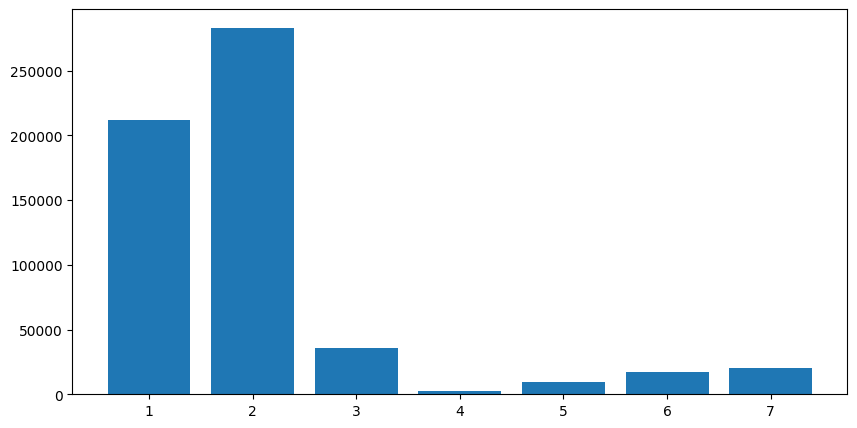

In [89]:
# TODO
import numpy as np
print(X.shape, y.shape)
print(f"Nombre de classes : {len(np.unique(y))}")
print(f"Classes équilibrées : {np.unique(y, return_counts=True)[1]}")

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 5))
plt.bar(np.unique(y), np.unique(y, return_counts=True)[1])

Notre jeu de données est composé de 581 012 observations composées de 54 variables plus la variable à prédire.
On constate que les classes sont peu équilibrées car certains types d'arbres sont bcp + présents.

### Question 2

Séparez le jeu de données en trois :
* un jeu d'entraînement avec 100 000 observations,
* un jeu de validation avec 100 000 observations,
* un jeu d'évaluation (reste).

Vous pouvez utiliser la fonction [`sklearn.model_selection.train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
Assurez-vous que la distribution des classes est identique dans les trois sous-jeux de données en utilisant le paramètre `stratify`.

In [90]:
# TODO
from sklearn.model_selection import train_test_split
x_train, x_remaining, y_train, y_remaining = train_test_split(X, y, train_size= 100000, stratify = y)
x_test, x_eval, y_test, y_eval = train_test_split(x_remaining, y_remaining, train_size= 100000, stratify = y_remaining)

### Question 3

Convertissez les tableaux NumPy en tenseurs PyTorch. N'oubliez pas de changer le type des données :
* les données en entrée (`X`) doivent passer de `numpy.float64` à `torch.float32`,
* les données en sortie (`y`) doivent passer de `numpy.int32` à `torch.int64`.

Vous pouvez utiliser la fonction [`torch.from_numpy()`](https://pytorch.org/docs/stable/generated/torch.from_numpy.html) et la méthode [`torch.Tensor.to()`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html).

> **Remarque** : Pour les tâches de classification, il est nécessaire de fournir une représentation adaptée des classes pour la fonction de coût. La représentation la plus simple pour une tâche de classification multi-classes est d'utiliser les $K$ premiers entiers naturels (en commençant à partir de zéro), c'est-à-dire les entiers $0, \ldots, K-1$, $K$ étant le nombre de classes. De cette manière, la correspondance entre la dernière couche du réseau de neurones (renvoyant les probabilités ou les logits) et les classes est basée sur les indicies : `probabilité[k]` correspond à la probabilité d'appartenir à la classe $k$ pour chaque $k \in \{ 0, \ldots, K-1 \}$.

In [91]:
# TODO
import torch
y = y-1
x_train = torch.from_numpy(x_train).to(torch.float32)
x_test = torch.from_numpy(x_test).to(torch.float32)
x_eval = torch.from_numpy(x_eval).to(torch.float32)

y_train = torch.from_numpy(y_train).to(torch.float64)
y_test = torch.from_numpy(y_test).to(torch.float64)
y_eval = torch.from_numpy(y_eval).to(torch.float64)


### Question 4

Créez des instances de la classe [`torch.utils.data.Dataloader()`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) pour chacun des jeux (entraînement, validation et évaluation). Pour les jeux de données, vous pouvez utiliser la classe [`torch.utils.data.TensorDataset()`](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset).

In [92]:
# TODO
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
eval_dataset = TensorDataset(x_eval, y_eval)

from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True, )
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = True)
eval_dataloader = DataLoader(eval_dataset, batch_size = 32, shuffle = True)


### Question 5

La définition des caractéristiques principales du modèle (architecture) et de son entraînement (algorithme d'optimisation, fonction de perte, métrique d'évaluation) se fait dans une même classe.
Complétez les méthodes `__init__()`, `forward()` et `configure_optimizers()` de la classe `NeuralNetwork` définie ci-dessous en utilisant les informations fournies dans le texte ci-dessous.

#### Architecture

L'architecture de votre réseau de neurones est un **perceptron multicouche** avec les caractéristiques suivantes :
* *Première couche cachée* : couche linéaire (128 variables en sortie) + fonction d'activation ReLU
* *Deuxième couche cachée* : couche linéaire (64 variables en sortie) + fonction d'activation ReLU
* *Dernière couche cachée* : couche linéaire (à vous de déterminer la taille de la sortie)

Pour rappel, les couches sont initialisées dans le constructeur et la définition de la passe avant se fait dans la méthode `forward()`.
Vous êtes encouragés à aller lire la documentation de [`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), [`torch.nn.ReLU()`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) et [`torch.nn.Sequential()`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html).

#### Entraînement

Le modèle sera entraîné en utilisant l'entropie croisée comme fonction de perte et Adam avec les valeurs par défaut pour ses hyperparamètres comme algorithme d'optimisation.
Vous êtes encouragés à aller lire la documentation de [`torch.nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) et [`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

#### Métrique

La performance d'un modèle sera évalué en utilisant l'exactitude (*accuracy*).
Vous pouvez utiliser [`torchmetrics.Accuracy()`](https://lightning.ai/docs/torchmetrics/stable/classification/accuracy.html).

In [98]:
import lightning as L
from torchmetrics import Accuracy


class NeuralNetwork(L.LightningModule):  # La classe hérite de la classe lightning.LightningModule

    def __init__(self):
        """Constructeur.

        Dans le constructeur, on exécute le constructeur de la clase mère et on définit
        toutes les couches et fonctions d'activation de notre réseau de neurones.
        """
        super().__init__()  # Toujours exécuter le constructeur de la classe mère

        ### BEGIN TODO ###
        # Initialisation de la séquence de couches et de fonctions d'activation
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(1*54, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,7)
        )
        # Initialisation de la fonction de perte
        self.loss = torch.nn.CrossEntropyLoss()

        # Initialisation des métriques d'évaluation
        self.accuracy_train = Accuracy(task="multiclass", num_classes=7)
        self.accuracy_val = Accuracy(task="multiclass", num_classes=7)
        self.accuracy_test = Accuracy(task="multiclass", num_classes=7)
        #### END TODO ####

    def forward(self, x):
        """Implémente la passe avant.

        L'argument x est un tenseur correspondant soit à l'entrée une seule
        observation soit aux entrées d'un lot d'observations.
        """
        ### BEGIN TODO ###
        y = self.sequential(x)
        #### END TODO ####
        return y

    def step(self, batch, dataset):
        """Effectue une étape.

        Une étape consiste à passer d'un lot d'observations (l'argument batch)
        à l'évaluation de la fonction de coût pour ce lot d'observations.

        Parameters
        ----------
        batch : tuple
            Un lot d'observations. Le premier élément du tuple est le lot
            des entrées, le second est le lot des labels.

        dataset : {"training", "validation", "test"}
            Jeu de données utilisé.

        Returns
        -------
        loss : Tensor, shape = (1,)
            La fonction de coût pour ce lot d'observations.
        """
        X, y = batch  # X correspond aux images, y aux classes
        logits = self(X)  # Passe avant, qui renvoie les logits
        loss = self.loss(logits, y)  # Évaluation de la fonction de perte
        y_pred = logits.argmax(1)  # Prédictions du modèle

        if dataset == "training":
            metric = self.accuracy_train
            name = "train"
            bar_step = True
        elif dataset == "validation":
            metric = self.accuracy_val
            name = "val"
            bar_step = False
        else:
            metric = self.accuracy_test
            name = "test"
            bar_step = False

        acc = metric(y_pred, y) # Évaluation de la métrique
        self.log(f"loss_{name}", loss, prog_bar=bar_step, on_step=bar_step, on_epoch=True)
        self.log(f"accuracy_{name}", acc, prog_bar=bar_step, on_step=bar_step, on_epoch=True)

        return loss

    def training_step(self, batch):
        """Effectue une étape d'entraînement."""
        return self.step(batch, "training")

    def validation_step(self, batch):
        """Effectue une étape de validation."""
        return self.step(batch, "validation")

    def test_step(self, batch):
        """Effectue une étape d'évaluation."""
        return self.step(batch, "test")

    def on_train_start(self):
        """Code exécuté au début de l'entraînement."""
        string = f"Version {self.trainer.logger.version}"
        print(f"{string}\n{'=' * len(string)}\n")

    def on_train_epoch_end(self):
        """Code exécuté à la fin de chaque époque d'entraînement."""
        metrics = self.trainer.callback_metrics
        string = (f"""
            Époque {self.trainer.current_epoch + 1} / {self.trainer.max_epochs}
            -------------------------------------------------
            |     Jeu      | Fonction de perte | Exactitude |
            | ------------ | ----------------- | ---------- |
            | Entraînement |{metrics['loss_train'].item():^19.5f}|{metrics['accuracy_train'].item():^12.3%}|
            |  Validation  |{metrics['loss_val'].item():^19.5f}|{metrics['accuracy_val'].item():^12.3%}|
            -------------------------------------------------
        """)
        string = '\n'.join([line.strip() for line in string.strip().split('\n')])
        print(string, "\n")

    def configure_optimizers(self):
        """Configure l'algorithme d'optimisation à utiliser."""
        ### BEGIN TODO ###
        optimizer = torch.optim.Adam(self.parameters())
        #### END TODO ####
        return optimizer

On va maintenant entraîner le modèle pendant 10 époques.

In [99]:
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.loggers import CSVLogger


model = NeuralNetwork()

trainer = L.Trainer(
    max_epochs=10,
    enable_model_summary=False,  # supprimer le résumé du modèle
    logger=CSVLogger('.'),  # sauvegarder les résultats dans un fichier CSV
    num_sanity_val_steps=0,  # ne pas effectuer d'étape de validation avant l'entraînement
    callbacks=[TQDMProgressBar(refresh_rate=100)]  # mettre à jour la barre de progression tous les 100 lots
)

trainer.fit(
    model=model,
    train_dataloaders=train_dataloader,
    val_dataloaders=eval_dataloader
)

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:484: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Version 2



NotImplementedError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Double'

### Question 6

Est-ce que l'exactitude (*accuracy*) est une métrique appropriée ici ?
Quelle métrique serait davantage pertinente ?
Y a-t-il également des modifications à faire pour potentiellement améliorer l'entraînement ?
Regardez la documentation de [`torchmetrics.Accuracy()`](https://lightning.ai/docs/torchmetrics/stable/classification/accuracy.html) et de [`torch.nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) et faîtes les modifications nécessaires dans la méthode `forward()`.
Vous pouvez utiliser la fonction [`torch.bincount()`](https://pytorch.org/docs/stable/generated/torch.bincount.html) pour compter le nombre d'observations pour les différentes classes.

> **Remarque** : L'exactitude équilibrée (*balanced accuracy*) nécessite de connaître la distribution des classes pour connaître les poids des classes. La distribution des classes étant connue à la fin (quand on a parcouru tout le jeu de données), il n'est donc pas possible de calculer les scores d'exactitude équilibrée sur tous les lots intermédiaires. La bonne approche est de *mettre à jour* la métrique (avec la méthode `update()`) à chaque étape (*step*), puis de calculer l'exactitude équilibrée à la fin de l'époque (avec la méthode `compute()`) et enfin de réinitialiser les informations sauvegardées sous le capot pour calculer l'exactitude équilibrée (avec la méthode `reset()`).

In [ ]:
import lightning as L
from torch import nn
from torchmetrics import Accuracy


class NeuralNetworkUpdated(L.LightningModule):  # La classe hérite de la classe lightning.LightningModule

    def __init__(self):
        """Constructeur.

        Dans le constructeur, on exécute le constructeur de la clase mère et on définit
        toutes les couches et fonctions d'activation de notre réseau de neurones.
        """
        super().__init__()  # Toujours exécuter le constructeur de la classe mère

        self.sequential = nn.Sequential(
            nn.Flatten(),
            nn.Linear(54, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 7),
        )

        ### BEGIN TODO ###
        # self.loss =
        # self.bal_acc_train =
        # self.bal_acc_val =
        # self.bal_acc_test =
        #### END TODO ####

    def forward(self, x):
        """Implémente la passe avant.

        L'argument x est un tenseur correspondant soit à l'entrée une seule
        observation soit aux entrées d'un lot d'observations.
        """
        return self.sequential(x)

    def step(self, batch, dataset):
        """Effectue une étape.

        Une étape consiste à passer d'un lot d'observations (l'argument batch)
        à l'évaluation de la fonction de coût pour ce lot d'observations.

        Parameters
        ----------
        batch : tuple
            Un lot d'observations. Le premier élément du tuple est le lot
            des entrées, le second est le lot des labels.

        dataset : {"training", "validation", "test"}
            Jeu de données utilisé.

        Returns
        -------
        loss : Tensor, shape = (1,)
            La fonction de coût pour ce lot d'observations.
        """
        X, y = batch  # X correspond aux images, y aux classes
        logits = self(X)  # Passe avant, qui renvoie les logits
        loss = self.loss(logits, y)  # Évaluation de la fonction de perte
        y_pred = logits.argmax(1)  # Prédictions du modèle

        if dataset == "training":
            metric = self.bal_acc_train
            name = "train"
            bar_step = True
        elif dataset == "validation":
            metric = self.bal_acc_val
            name = "val"
            bar_step = False
        else:
            metric = self.bal_acc_test
            name = "test"
            bar_step = False

        acc = metric(y_pred, y) # Évaluation de la métrique
        self.log(f"weighted_loss_{name}", loss, prog_bar=bar_step, on_step=bar_step, on_epoch=True)
        self.log(f"balanced_accuracy_{name}", acc, prog_bar=bar_step, on_step=bar_step, on_epoch=True)

        return loss

    def training_step(self, batch):
        """Effectue une étape d'entraînement."""
        return self.step(batch, "training")

    def validation_step(self, batch):
        """Effectue une étape de validation."""
        return self.step(batch, "validation")

    def test_step(self, batch):
        """Effectue une étape d'évaluation."""
        return self.step(batch, "test")

    def on_train_start(self):
        """Code exécuté au début de l'entraînement."""
        string = f"Version {self.trainer.logger.version}"
        print(f"{string}\n{'=' * len(string)}\n")

    def on_train_epoch_end(self):
        """Code exécuté à la fin de chaque époque d'entraînement."""
        self.log('balanced_accuracy_train', self.bal_acc_train.compute())
        self.bal_acc_train.reset()

        metrics = self.trainer.callback_metrics
        weighted_loss_train = metrics['weighted_loss_train'].item()
        weighted_loss_val = metrics['weighted_loss_val'].item()
        bal_acc_train = metrics['balanced_accuracy_train'].item()
        bal_acc_val = metrics['balanced_accuracy_val'].item()

        string = (f"""
            Époque {self.trainer.current_epoch + 1} / {self.trainer.max_epochs}
            ------------------------------------------------------------
            |     Jeu      | Fonction de perte | Exactitude équilibrée |
            | ------------ | ----------------- | --------------------- |
            | Entraînement |{weighted_loss_train:^19.5f}|{bal_acc_train:^23.3%}|
            |  Validation  |{weighted_loss_val:^19.5f}|{bal_acc_val:^23.3%}|
            ------------------------------------------------------------
        """)
        string = '\n'.join([line.strip() for line in string.strip().split('\n')])
        print(string, "\n")

    def on_validation_epoch_end(self):
        self.log('bal_acc_val', self.bal_acc_val.compute())
        self.bal_acc_val.reset()

    def on_test_epoch_end(self):
        self.log('bal_acc_test', self.bal_acc_test.compute())
        self.bal_acc_test.reset()

    def configure_optimizers(self):
        """Configure l'algorithme d'optimisation à utiliser."""
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

On entraîne un nouveau modèle pendant $10$ époques également.

In [ ]:
model_updated = NeuralNetworkUpdated()

trainer = L.Trainer(
    max_epochs=10,
    enable_model_summary=False,  # supprimer le résumé du modèle
    logger=CSVLogger('.'),  # sauvegarder les résultats dans un fichier CSV
    num_sanity_val_steps=0,  # ne pas effectuer d'étape de validation avant l'entraînement
    callbacks=[TQDMProgressBar(refresh_rate=100)]  # mettre à jour la barre de progression tous les 100 lots
)

trainer.fit(
    model=model_updated,
    train_dataloaders=dataloader_train,
    val_dataloaders=dataloader_val
)

### Question 7

Faîtes les modifications que vous souhaitez, par exemple au niveau de l'architecture ou de la procédure d'entraînement, et entraînez vos nouveaux modèles.
**Gardez vos modèles précédents** et créez de nouveaux objets à chaque fois, afin de pouvoir comparer ces différents modèles ensuite.

In [ ]:
# TODO

### Question 8

Quand vous avez fini toutes vos expériences, il est temps de choisir le meilleur modèle sur le jeu de validation.
Évaluez sa performance sur le jeu d'évaluation.
Par curiosité, évaluez également la performance des autres modèles sur le jeu d'évaluation.
Vous êtes encouragés à aller lire la [documentation](https://lightning.ai/docs/torchmetrics/stable/pages/overview.html) de `torchmetrics` pour découvrir le principe d'utilisation des métriques implémentées dans ce paquet.

> **Remarque** : La première classe utilise l'exactitude (*accuracy*) comme métrique d'évaluation, tandis que la deuxième classe utilise l'exactitude équilibrée (*balanced accuracy*). Il n'est évidemment pas pertinent de comparer des scores d'exactitude avec des scores d'exactitude équilibrée. De même, la fonction de perte est maintenant pondérée dans la deuxième classe. Il n'est donc pas possible d'utiliser les méthodes `validate()` et `test()` pour comparer des modèles définis par des classes différentes si les classes utilisent différents critères d'évaluation.

In [ ]:
# TODO